[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/NaiveBayes.ipynb)
# Naive Bayes
In Naive Bayes, we learn:
- a *prior* for the probability of each class by counting relative frequency of class labels in the dataset.
    - for multi-class classification, wich $C$ classes, this is a categorical distribution $\mathrm{Categorical}(y=c_0; \pi) = \prod_c \pi_c^{\mathbb{I}(y=c)} = \pi_{c_0}$. MLE is given by $\pi_c = \frac{N(y=c)}{N}$.
- a probability for the value of each feature $x_d$, conditioned on the class label $y$. The type of this probability distribution depends on the feature type. Here, we only consider the **Gaussian** distribution: $p(x_d| y=c, \mathcal{D}) = \mathcal{N}(x_d; \mu_{d,c}, \sigma_{d,c})$. The maximum likelihood is given by the empirical mean and variance of feature $x_d$ for instances belonging to class $c$.

Once we learn both the class prior $p(y)$ and class conditionals $p(x_d|y)$ from the data, we can use the Bayes rule to calculate posterior class probability
$p(y| x) \propto p(y) p(x| y)$. 

In [20]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
# Set random seed for reproducibility
np.random.seed(1234)

## Fitting the data
Below, first we implement the `fit` function that learns the model parameters. We use Laplace smoothing for the class prior using $\alpha=\beta=1$.

In [21]:

class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier for multi-class classification.
    
    Assumes features are conditionally independent given the class (naive assumption).
    Models each feature's class-conditional distribution as Gaussian.
    """
    
    def __init__(self):
        """Initialize the Gaussian Naive Bayes classifier."""
        return
    
    def fit(self, x, y):
        """
        Fit the model by computing class priors and Gaussian parameters.
        
        Parameters:
        x: input features, shape (N, D) where N=samples, D=features
        y: class labels, shape (N,) with values in {0, 1, ..., C-1}
        
        Returns:
        self: fitted model with learned parameters
        """
        # Get dataset dimensions
        N, D = x.shape  # N = number of samples, D = number of features
        
        # Determine number of classes
        # If classes are {0, 1, 2}, then max(y)=2, so C=3
        C = np.max(y) + 1
        
        # Initialize parameter arrays
        # mu[c, d] = mean of feature d for class c
        # sigma[c, d] = standard deviation of feature d for class c
        # Shape: (C, D) - one Gaussian parameter per (class, feature) pair
        mu, sigma = np.zeros((C, D)), np.zeros((C, D))
        
        # Nc[c] = number of training samples in class c
        Nc = np.zeros(C)
        
        # For each class, compute MLE estimates of Gaussian parameters
        for c in range(C):
            # Advanced indexing: y == c creates boolean mask of shape (N,)
            # True where sample belongs to class c, False otherwise
            # x[y == c] selects only rows (samples) where mask is True
            # Result x_c has shape (Nc, D) where Nc = count of class c samples
            x_c = x[y == c]
            
            # Get number of samples in this class
            Nc[c] = x_c.shape[0]
            
            # Compute mean for each feature in this class
            # np.mean(x_c, 0) computes mean along axis 0 (across samples)
            # Result has shape (D,) - one mean per feature
            # mu[c, :] assigns to row c (all columns) of mu matrix
            mu[c, :] = np.mean(x_c, 0)
            
            # Compute standard deviation for each feature in this class
            # np.std(x_c, 0) computes std along axis 0 (across samples)
            # Result has shape (D,) - one std per feature
            sigma[c, :] = np.std(x_c, 0)
        
        # Store learned parameters as instance variables
        self.mu = mu        # shape (C, D)
        self.sigma = sigma  # shape (C, D)
        
        # Compute class prior probabilities with Laplace smoothing
        # Without smoothing: pi_c = Nc / N
        # With Laplace smoothing (α=1 for all classes): pi_c = (Nc + 1) / (N + C)
        # This prevents zero probabilities for unseen classes
        # Equivalent to adding one pseudo-observation to each class
        self.pi = (Nc + 1) / (N + C)  # shape (C,)
        
        return self

## Prediction for new data
So far we have produced model parameters. To calculate the posterior for new instances, we need to evaluate
$$
\tilde{p}(y=c| x) = \mathrm{Categorical}(c; \pi) \prod_{d} \mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c})
$$
with large number of features $D$, the product will encounter a numerical problem since it can grow too large or too small.
For this reason we work in the log domain:
$$
\log \tilde{p}(y=c| x) = \log(\pi_c) +  \sum_{d} \log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right)
$$
Logarithm of the Gaussian takes the following form:
$$
\log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right) = -\frac{1}{2} \log(2\pi) - \log(\sigma_{d,c}) -  \frac{(x - \mu_{d,c})^2}{2\sigma_{d,c}^2}.
$$

### Normalization and numerical stability
At this point we have logarithm of **unnormalized** posterior $\log \tilde{p}(y=c| x, \mathcal{D}) \forall c$. 
To get the probabilities, we need to normalize. We can do this in the log domain as well:
$$
\log p(y=c|x) =  (\log \tilde{p}(y=c| x)) - \log \left (\sum_{c'} \exp (\log \tilde{p}(y=c| x)) \right )
$$
Again, this could run into numerical issues because of large numbers in the exponent inside log-sum-exp. Here, we use the **log-sum-exp** trick, which uses the fact that
$
\log \sum_c \exp (z_c) = z_{\max} + \log \sum_c \exp (z_c - z_\max)
$.
In fact, one could replace $z_{max}$ with any constant. However, to help the numerical stability we use either min or max, so that all the values in the exponent are closer to zero.

In [22]:
def logsumexp(Z):
    """
    Compute log(sum(exp(Z))) using the log-sum-exp trick for numerical stability.
    
    This prevents overflow/underflow when exponentiating large/small numbers.
    Uses: log(Σ exp(z_i)) = z_max + log(Σ exp(z_i - z_max))
    
    Parameters:
    Z: array of shape (C, N) where C=classes, N=test samples
    
    Returns:
    log_sum_exp: array of shape (N,)
    """
    # Find maximum value for each sample (column)
    # np.max(Z, axis=0) computes max over axis 0 (classes), shape (N,)
    # [None, :] adds new axis: (N,) -> (1, N) for broadcasting
    Zmax = np.max(Z, axis=0)[None, :]  # shape (1, N)
    
    # Apply log-sum-exp trick
    # Z - Zmax broadcasts: (C, N) - (1, N) = (C, N)
    # Subtracting Zmax makes values ≤ 0, preventing overflow in exp
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    
    return log_sum_exp

def predict(self, xt):
    """
    Predict class probabilities for test samples using Bayes' rule.
    
    Computes: P(y=c|x) ∝ P(y=c) * P(x|y=c)
    Works in log domain for numerical stability.
    
    Parameters:
    xt: test features, shape (Nt, D)
    
    Returns:
    posterior: class probabilities, shape (Nt, C)
               posterior[n, c] = P(y=c | x_n)
    """
    Nt, D = xt.shape
    
    # ===== COMPUTING LOG PRIOR =====
    # self.pi has shape (C,) containing class prior probabilities
    # np.log(self.pi) computes log of each prior
    # [:, None] adds new axis: (C,) -> (C, 1) for broadcasting
    # This will broadcast with log-likelihood matrix (C, Nt)
    log_prior = np.log(self.pi)[:, None]  # shape (C, 1)
    
    # ===== COMPUTING LOG LIKELIHOOD =====
    # Evaluate Gaussian PDF in log domain:
    # log N(x; μ, σ²) = -0.5*log(2π) - log(σ) - (x-μ)²/(2σ²)
    #
    # Broadcasting strategy to handle (C, Nt, D):
    # - self.sigma has shape (C, D): std for each (class, feature) pair
    # - xt has shape (Nt, D): test samples
    # - Need to compute likelihood for each (class, test_sample, feature)
    #
    # Adding dimensions:
    # - self.sigma[:, None, :] converts (C, D) -> (C, 1, D)
    # - xt[None, :, :] converts (Nt, D) -> (1, Nt, D)
    # - self.mu[:, None, :] converts (C, D) -> (C, 1, D)
    # Broadcasting: (C, 1, D) with (1, Nt, D) -> (C, Nt, D)
    #
    # Three terms of log Gaussian:
    # 1. -0.5 * log(2π): constant normalization
    # 2. -log(σ): shape (C, 1, D) broadcasts to (C, Nt, D)
    # 3. -(x-μ)²/(2σ²): centered and scaled squared error
    log_likelihood = (
        -0.5 * np.log(2 * np.pi)  # Normalization constant
        - np.log(self.sigma[:, None, :])  # -log(σ), broadcasts to (C, Nt, D)
        - 0.5 * (((xt[None, :, :] - self.mu[:, None, :]) / self.sigma[:, None, :]) ** 2)
    )  # shape (C, Nt, D)
    
    # Sum over feature dimension (axis 2) to get total log-likelihood
    # Result shape: (C, Nt)
    # log_likelihood[c, n] = log P(x_n | y=c) = Σ_d log P(x_n,d | y=c)
    # (naive assumption: features are independent given class)
    log_likelihood = np.sum(log_likelihood, axis=2)  # shape (C, Nt)
    
    # ===== COMPUTING LOG POSTERIOR =====
    # log P(y=c | x_n) ∝ log P(y=c) + log P(x_n | y=c)
    # Broadcasting: (C, 1) + (C, Nt) = (C, Nt)
    log_posterior = log_prior + log_likelihood  # shape (C, Nt)
    
    # ===== NORMALIZING TO GET PROBABILITIES =====
    # Convert from log of unnormalized posterior to normalized probabilities
    # P(y=c|x) = exp(log P̃(y=c|x)) / Σ_c' exp(log P̃(y=c'|x))
    # In log: log P(y=c|x) = log P̃(y=c|x) - log(Σ_c' exp(log P̃(y=c'|x)))
    # logsumexp computes denominator with numerical stability
    posterior = np.exp(log_posterior - logsumexp(log_posterior))  # shape (C, Nt)
    
    # Transpose to conventional format: (Nt, C)
    # Each row is a test sample, each column is a class
    # posterior[n, c] = P(y=c | x_n)
    return posterior.T  # shape (Nt, C)

# Attach the predict method to the GaussianNaiveBayes class
GaussianNaiveBayes.predict = predict

## Experiment
Next, we apply the model to classify the Iris dataset. As before we only use two features for better visualization.

In [23]:
from sklearn import model_selection

# Load the Iris dataset
# x has shape (150, 4) with 4 features
# y has shape (150,) with 3 classes: 0, 1, 2
x, y = datasets.load_iris(return_X_y=True)

# Use only first 2 features for 2D visualization
# x[:, :2] selects all rows, columns 0 and 1
x = x[:, :2]  # shape (150, 2)

# Split into training (80%) and test (20%) sets
# Stratified split maintains class proportions in both sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.2
)

# Create and train the model
model = GaussianNaiveBayes()
model.fit(x_train, y_train)

# Get class probability predictions for test set
# y_prob has shape (Nt, C) where Nt=30, C=3
y_prob = model.predict(x_test)

# Convert probabilities to hard class predictions
# np.argmax(y_prob, 1) finds class with highest probability
# axis=1 means argmax over columns (classes) for each row (sample)
y_pred = np.argmax(y_prob, 1)  # shape (Nt,)

# Compute accuracy: fraction of correct predictions
# y_pred == y_test creates boolean array
# np.sum counts True values (correct predictions)
accuracy = np.sum(y_pred == y_test) / y_pred.shape[0]

print(f'test accuracy: {accuracy}')

test accuracy: 0.8


## Decision boundary
This is the same procedure we used for drawing) the decision boundary and probabilities produced for the K-NN and the Decision tree.
We also mark the mean of the Gaussian for each class using a `x`.

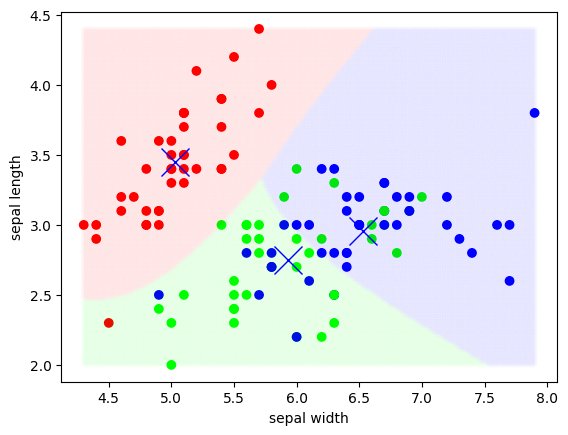

In [24]:
# Get total number of classes
num_classes = np.max(y) + 1  # If max(y)=2, then num_classes=3

# Create a dense grid covering the 2D feature space
# This visualizes decision boundaries across the entire space

# Generate 200 evenly spaced values for each feature
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)  # feature 0
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)  # feature 1

# Create 2D meshgrid
# x0 and x1 are both (200, 200) arrays
x0, x1 = np.meshgrid(x0v, x1v)

# Flatten and combine into array of all grid points
# ravel() flattens (200, 200) -> (40000,)
# vstack creates (2, 40000), transpose gives (40000, 2)
# Each row is a 2D point [x0, x1]
x_all = np.vstack((x0.ravel(), x1.ravel())).T  # shape (40000, 2)

# Create one-hot encoded labels for training data (for coloring)
# Initialize array of zeros with shape (N_train, num_classes)
y_train_prob = np.zeros((y_train.shape[0], num_classes))

# Advanced indexing to create one-hot encoding
# np.arange(y_train.shape[0]) creates [0, 1, 2, ..., N_train-1]
# y_train contains class labels
# y_train_prob[i, y_train[i]] = 1 sets the true class to 1
# Example: if y_train[5] = 2, then y_train_prob[5, :] = [0, 0, 1]
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

# Fit model and predict probabilities for all grid points
y_prob_all = model.fit(x_train, y_train).predict(x_all)  # shape (40000, 3)

# Create one-hot encoded predictions for grid points (hard boundaries)
# Initialize array of zeros
y_pred_all = np.zeros_like(y_prob_all)  # shape (40000, 3)

# For each grid point, set probability to 1 for predicted class
# np.argmax(y_prob_all, 1) finds class with max probability
# Advanced indexing sets that class to 1, others to 0
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, 1)] = 1

# ===== PLOTTING =====
# Plot 1: Training data points
# x_train[:, 0] is first feature, x_train[:, 1] is second feature
# c=y_train_prob colors by one-hot encoded class
# RGB: [1,0,0]=red (class 0), [0,1,0]=green (class 1), [0,0,1]=blue (class 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_prob, marker='o', alpha=1)

# Plot 2: Decision regions (background)
# Scatter all grid points with their predicted classes
# marker='.' creates tiny dots, alpha=.01 for transparency
# Creates colored background showing decision regions
plt.scatter(x_all[:, 0], x_all[:, 1], c=y_pred_all, marker='.', alpha=.01)

# Plot 3: Class centers (Gaussian means)
# model.mu has shape (C, D) = (3, 2)
# model.mu[:, 0] is first feature mean for each class
# model.mu[:, 1] is second feature mean for each class
# 'bx' = blue X markers, markersize=20 makes them large
plt.plot(model.mu[:, 0], model.mu[:, 1], 'bx', markersize=20)

# Add labels
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

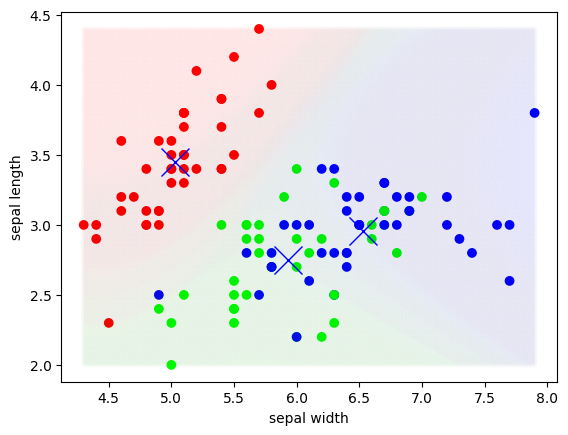

In [25]:
# ===== VISUALIZATION WITH SOFT PROBABILITIES =====
# This shows actual class probabilities (not hard decision boundaries)
# Gives a smoother, more nuanced view of the model's confidence

# Plot 1: Training data points (colored by true class)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_prob, marker='o', alpha=1)

# Plot 2: Probability landscape (background)
# Instead of one-hot predictions, use raw probabilities
# y_prob_all has shape (40000, 3) with values in [0, 1]
# Each point's color is blended based on class probabilities
# Example: if y_prob_all[i] = [0.7, 0.2, 0.1], color is 70% red, 20% green, 10% blue
# This creates a gradient showing confidence across the feature space
# High confidence areas are saturated; uncertain areas are mixed colors
plt.scatter(x_all[:, 0], x_all[:, 1], c=y_prob_all, marker='.', alpha=.01)

# Plot 3: Class centers (Gaussian means)
# Mark the learned mean for each class with a large blue X
# model.mu[:, 0] selects all classes, first feature
# model.mu[:, 1] selects all classes, second feature
plt.plot(model.mu[:, 0], model.mu[:, 1], 'bx', markersize=20)

# Add labels
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()